In [1]:
import cv2
import numpy as np
import os
import h5py
import pandas as pd
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from keras.preprocessing import image

In [2]:
train=pd.read_csv('train_new.csv')

In [3]:
train.tail()

,image,class
8613,Normal_frame842400.jpg,Normal
8614,Normal_frame842700.jpg,Normal
8615,Normal_frame843000.jpg,Normal
8616,Normal_frame843300.jpg,Normal
8617,Normal_frame843600.jpg,Normal


In [4]:
train_image = []

for i in tqdm(range(train.shape[0])):
    img = image.load_img('train_data/'+train['image'][i], target_size=(64,64,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|█████████████████████████████████████████████████████████████████████████████| 8618/8618 [00:49<00:00, 175.12it/s]


In [5]:
y=train['class']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [8]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6894, 64, 64, 3) (6894, 5) (1724, 64, 64, 3) (1724, 5)


In [10]:
# normalize data
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

x_train /= 127.5
x_test /= 127.5

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(32, (3, 3),activation='relu', padding='same', input_shape=(64,64,3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [13]:
model.compile(
    loss= 'categorical_crossentropy', 
    optimizer=Adam(lr=0.001, decay=1e-04),
    metrics=['accuracy']
)

C:\Users\ganes\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [15]:
model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=5,
    validation_data=(X_test, y_test),
    shuffle=True
)


Epoch 1/5
69/69 [==============================] - 29s 413ms/step - loss: 1.1634 - accuracy: 0.6377 - val_loss: 0.5875 - val_accuracy: 0.8521
Epoch 2/5
69/69 [==============================] - 29s 418ms/step - loss: 0.3091 - accuracy: 0.8899 - val_loss: 0.2213 - val_accuracy: 0.9397
Epoch 3/5
69/69 [==============================] - 37s 543ms/step - loss: 0.1425 - accuracy: 0.9524 - val_loss: 0.1127 - val_accuracy: 0.9751
Epoch 4/5
69/69 [==============================] - 39s 568ms/step - loss: 0.0902 - accuracy: 0.9713 - val_loss: 0.0736 - val_accuracy: 0.9832
Epoch 5/5
69/69 [==============================] - 34s 487ms/step - loss: 0.0564 - accuracy: 0.9811 - val_loss: 0.0480 - val_accuracy: 0.9890


In [16]:
y_pred = model.predict(X_test, batch_size=10, verbose=0)

In [17]:
y_predict = []
for i in range(0, len(y_pred)):
    y_predict.append(int(np.argmax(y_pred[i])))
len(y_predict)

1724

In [18]:
y_test

,Arson,Burglary,Explosion,Fighting,Normal
1420,1,0,0,0,0
2283,0,1,0,0,0
6903,0,0,0,1,0
5049,0,0,1,0,0
4427,0,0,1,0,0
...,...,...,...,...,...
4239,0,0,1,0,0
6502,0,0,0,1,0
5374,0,0,1,0,0
469,1,0,0,0,0


In [19]:
y_true = []
y_test1 = np.array(y_test)
for i in range(0, len(y_test1)):
    y_true.append(int(np.argmax(y_test1[i])))
len(y_true)

1724

In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [21]:
class_names =['Arson','Burglary','Explosion','Fighting','Normal']

In [22]:
cm_plot_labels = class_names

In [23]:
l=len(y_true)
for i in range(l):
    print(y_true[i],'----',y_predict[i])

0 ---- 0
1 ---- 1
3 ---- 3
2 ---- 2
2 ---- 2
2 ---- 2
3 ---- 3
3 ---- 3
3 ---- 3
3 ---- 3
2 ---- 2
3 ---- 3
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
1 ---- 1
1 ---- 1
0 ---- 0
3 ---- 3
4 ---- 4
0 ---- 0
2 ---- 2
3 ---- 3
3 ---- 3
3 ---- 3
4 ---- 4
2 ---- 2
4 ---- 4
0 ---- 0
1 ---- 1
3 ---- 3
0 ---- 4
0 ---- 0
0 ---- 0
3 ---- 3
0 ---- 0
3 ---- 3
0 ---- 0
1 ---- 1
2 ---- 2
3 ---- 3
3 ---- 3
3 ---- 3
0 ---- 0
2 ---- 2
3 ---- 3
3 ---- 3
2 ---- 2
3 ---- 0
0 ---- 0
2 ---- 2
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
3 ---- 3
3 ---- 3
0 ---- 0
3 ---- 3
0 ---- 0
0 ---- 0
2 ---- 2
2 ---- 2
3 ---- 3
3 ---- 3
0 ---- 0
3 ---- 3
3 ---- 3
3 ---- 1
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
3 ---- 3
1 ---- 1
1 ---- 1
2 ---- 2
2 ---- 2
3 ---- 3
2 ---- 2
3 ---- 3
0 ---- 0
2 ---- 2
2 ---- 2
0 ---- 0
0 ---- 0
1 ---- 1
3 ---- 3
0 ---- 0
2 ---- 2
4 ---- 4
3 ---- 3
3 ---- 3
3 ---- 3
2 ---- 2
3 ---- 3
2 ---- 2
4 ---- 1
3 ---- 3
1 ---- 1
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
1 ---- 1
3

4 ---- 4
3 ---- 3
0 ---- 0
2 ---- 2
4 ---- 4
3 ---- 3
0 ---- 0
2 ---- 2
2 ---- 2
2 ---- 2
3 ---- 3
4 ---- 4
3 ---- 3
2 ---- 2
2 ---- 2
3 ---- 3
3 ---- 3
3 ---- 3
2 ---- 2
3 ---- 3
4 ---- 4
0 ---- 0
2 ---- 2
0 ---- 0
0 ---- 0
0 ---- 0
2 ---- 2
3 ---- 3
2 ---- 2
3 ---- 3
2 ---- 2
3 ---- 3
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
0 ---- 0
0 ---- 0
2 ---- 2
2 ---- 2
1 ---- 1
2 ---- 2
0 ---- 0
3 ---- 3
1 ---- 1
0 ---- 0
2 ---- 2
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
3 ---- 3
2 ---- 2
4 ---- 4
0 ---- 0
2 ---- 2
2 ---- 2
0 ---- 0
2 ---- 2
2 ---- 2
2 ---- 2
2 ---- 2
0 ---- 0
4 ---- 4
3 ---- 3
1 ---- 1
2 ---- 2
0 ---- 0
1 ---- 1
2 ---- 2
2 ---- 2
3 ---- 3
2 ---- 2
2 ---- 2
0 ---- 0
1 ---- 1
3 ---- 3
0 ---- 0
1 ---- 1
3 ---- 3
0 ---- 0
2 ---- 2
0 ---- 0
3 ---- 3
2 ---- 2
2 ---- 2
3 ---- 3
2 ---- 2
2 ---- 2
2 ---- 2
3 ---- 3
2 ---- 2
3 ---- 3
3 ---- 3
3 ---- 3
3 ---- 3
2 ---- 2
2 ---- 2
0 ---- 0
3 ---- 3
0 ---- 0
3 ---- 3
2 ---- 2
0 ---- 0
3 ---- 3
0 ---- 0
0 ---- 0
3 ---- 3
0 ---- 0
3

In [24]:
print(classification_report(y_true=y_true,y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       360
           1       0.98      0.99      0.98       215
           2       1.00      1.00      1.00       665
           3       0.99      0.97      0.98       361
           4       0.96      0.99      0.98       123

    accuracy                           0.99      1724
   macro avg       0.98      0.99      0.99      1724
weighted avg       0.99      0.99      0.99      1724



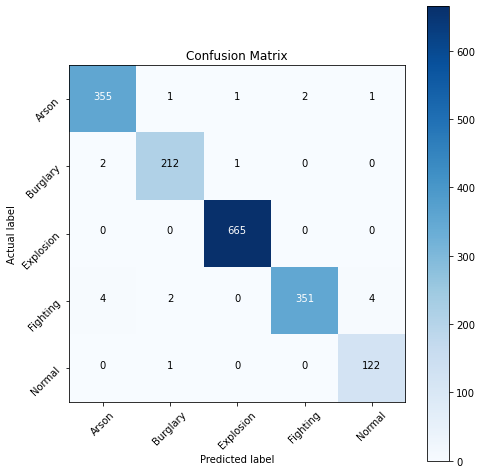

In [25]:
# to plot confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_predict)
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [26]:
acc_rf = accuracy_score(y_true=y_true, y_pred= y_predict)
print("Overall accuracy of CNN model using test-set is : %f" %(acc_rf*100))

Overall accuracy of CNN model using test-set is : 98.897912


In [27]:
model_structure = model.to_json()
f = Path("models/model_structure.json")
f.write_text(model_structure)

3262

model.save_weights("models/model_weights.h5")

In [28]:
model.save_weights("models/model_weights.h5")